<a href="https://colab.research.google.com/github/chandank21/Electrical-Household-Load-Forecasting/blob/main/Load_Forecasting_using_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from  sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import explained_variance_score,mean_squared_error,mean_absolute_percentage_error
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
import seaborn as sns
from keras.models import load_model
import sklearn.preprocessing 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

Data Analysis


In [4]:
energy_data = pd.read_csv('/content/drive/MyDrive/forecasting/Dataset_Panama/energy_data.csv')
weather_data= pd.read_csv('/content/drive/MyDrive/forecasting/Dataset_Panama/Barcelona.csv')
print("Forecasting for city:",weather_data.city_name[0])

Forecasting for city:  Barcelona


In [5]:
weather_data=weather_data.drop(["city_name"],axis=1)
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   time        35064 non-null  object 
 1   temp        35064 non-null  float64
 2   temp_min    35064 non-null  float64
 3   temp_max    35064 non-null  float64
 4   pressure    35064 non-null  float64
 5   humidity    35064 non-null  float64
 6   wind_speed  35064 non-null  float64
 7   wind_deg    35064 non-null  float64
 8   rain_1h     35064 non-null  float64
 9   rain_3h     35064 non-null  float64
 10  snow_3h     35064 non-null  float64
 11  clouds_all  35064 non-null  float64
dtypes: float64(11), object(1)
memory usage: 3.2+ MB


In [6]:
energy_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   time               35064 non-null  object 
 1   total load actual  35064 non-null  float64
 2   price day ahead    35064 non-null  float64
 3   price actual       35064 non-null  float64
dtypes: float64(3), object(1)
memory usage: 1.1+ MB


Data Preprocessing

In [7]:
env_data_df=pd.merge(energy_data,weather_data,on="time")
env_data_df=env_data_df.set_index("time")

In [9]:
def normalize_data(df):
    scaler = sklearn.preprocessing.MinMaxScaler()
    df=scaler.fit_transform(df)
    return df

df_norm = normalize_data(env_data_df)
df_norm.shape

(35064, 14)

In [10]:
train_df=pd.DataFrame(df_norm,columns=env_data_df.columns,index=env_data_df.index)

In [11]:
X=train_df.drop(["total load actual"],axis=1)
y=train_df["total load actual"]


In [12]:
X=X[:35000]
y=y[:35000]

In [13]:
def lstm_data_transform(x_data, y_data, num_steps=24):
    """ Changes data to the format for LSTM training 
for sliding window approach """       # Prepare the list for the transformed data
    X, y = list(), list()             # Loop of the entire data set
    for i in range(x_data.shape[0]):
        # compute a new (sliding window) index
        end_ix = i + num_steps        # if index is larger than the size of the dataset, we stop
        if end_ix >= x_data.shape[0]:
            break                     # Get a sequence of data for x
        seq_X = x_data[i:end_ix]
        # Get only the last element of the sequency for y
        seq_y = y_data[end_ix]        # Append the list with sequencies
        X.append(seq_X)
        y.append(seq_y)    # Make final arrays
    x_array = np.array(X)
    y_array = np.array(y)    
    return x_array, y_array

In [14]:
#create train, test data
seq_len = 24                       #choose sequence length
X,y = lstm_data_transform(X,y, 24)
print('X = ',X.shape)
print('y = ', y.shape)

X =  (34976, 24, 13)
y =  (34976,)


Data in test-train format

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Data Visualisation

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f259363f810>,
      dtype=object)

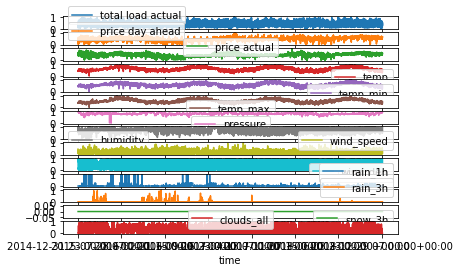

In [17]:
##Pattern in different features to be learned by the model we train
train_df.plot(subplots=True)

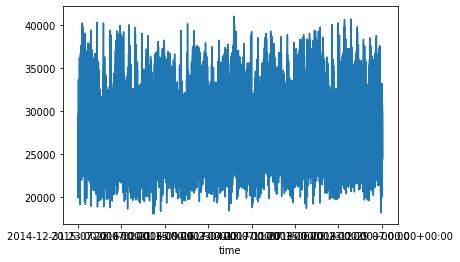

In [18]:
#Load or target feature distribution over whole timeframe
env_data_df["total load actual"].plot()

# Models...

LSTM Model Training

In [44]:
### LSTM MODEL

lstm_model = Sequential()

lstm_model.add(LSTM(50,activation="tanh",return_sequences=True, input_shape=(24,13)))
lstm_model.add(Dropout(0.05))

lstm_model.add(LSTM(20,activation="tanh",return_sequences=False))
lstm_model.add(Dropout(0.15))

lstm_model.add(Dense(1))

lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 24, 50)            12800     
                                                                 
 dropout_2 (Dropout)         (None, 24, 50)            0         
                                                                 
 lstm_4 (LSTM)               (None, 20)                5680      
                                                                 
 dropout_3 (Dropout)         (None, 20)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 18,501
Trainable params: 18,501
Non-trainable params: 0
_________________________________________________________________


In [45]:
lstm_model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
history=lstm_model.fit(X_train, y_train,validation_split=0.20, epochs=10,) 


Epoch 1/10
613/613 [==============================] - 85s 31ms/step - loss: 0.0501 - root_mean_squared_error: 0.2239 - val_loss: 0.0377 - val_root_mean_squared_error: 0.1942
Epoch 2/10
613/613 [==============================] - 16s 26ms/step - loss: 0.0379 - root_mean_squared_error: 0.1948 - val_loss: 0.0299 - val_root_mean_squared_error: 0.1729
Epoch 3/10
613/613 [==============================] - 17s 27ms/step - loss: 0.0297 - root_mean_squared_error: 0.1724 - val_loss: 0.0245 - val_root_mean_squared_error: 0.1564
Epoch 4/10
613/613 [==============================] - 17s 27ms/step - loss: 0.0278 - root_mean_squared_error: 0.1666 - val_loss: 0.0235 - val_root_mean_squared_error: 0.1532
Epoch 5/10
613/613 [==============================] - 16s 26ms/step - loss: 0.0262 - root_mean_squared_error: 0.1619 - val_loss: 0.0228 - val_root_mean_squared_error: 0.1508
Epoch 6/10
613/613 [==============================] - 17s 28ms/step - loss: 0.0256 - root_mean_squared_error: 0.1600 - val_loss: 0

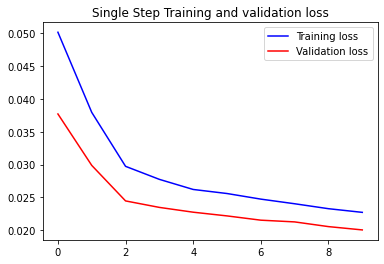

In [46]:
plot_train_history(history,'Single Step Training and validation loss')

Prediction

In [47]:
from sklearn.metrics import r2_score
lstm_predictions = lstm_model.predict(X_test)

lstm_score = r2_score(y_test, lstm_predictions)
print("R^2 Score of LSTM model = ",lstm_score)

R^2 Score of LSTM model =  0.5039015579480101


Prediction : Visualisation

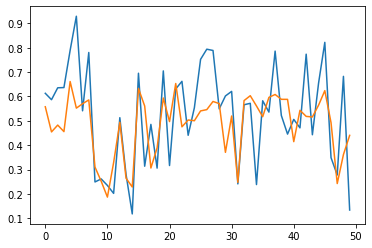

In [53]:
plt.plot(y_test[:50]) # plot y_test
plt.plot(lstm_predictions[:50]) # plot y_pred

# Bayesian Optimisation for hyperparameter Tuning

In [54]:
!pip install keras-tuner -q

In [55]:
from tensorflow import keras
import keras_tuner
from keras_tuner.tuners import BayesianOptimization
import os

In [56]:
def build(hp):
    activation = hp.Choice('activation', 
                        [
                          'relu',
                          'tanh',
                          'linear',
                        ])

    num_rnn_layers = hp.Int(
                        'num_rnn_layers', 
                        min_value=1,
                        max_value=6,
                        default=3)

    recurrent_dropout = hp.Float(
                        'recurrent_dropout', 
                        min_value=0.0,
                        max_value=0.70,
                        default=0.2)
    num_units = hp.Int(
                        'num_units', 
                        min_value=11,
                        max_value=81,
                        default=32)
    
    model = Sequential()
    for layer in range(num_rnn_layers):
        if layer==0:
            model.add(LSTM(units=num_units, activation=activation, return_sequences=True,recurrent_dropout = recurrent_dropout,input_shape=(24, 13)))
        elif layer==(num_rnn_layers-1):
            model.add(LSTM(units=num_units, activation=activation,return_sequences=False, recurrent_dropout = recurrent_dropout,))
        else:
            model.add(LSTM(units=num_units, activation=activation,return_sequences=True, recurrent_dropout = recurrent_dropout,))
          
    model.add(Dense(1))
    model.compile(loss='mean_absolute_error', metrics=[RootMeanSquaredError()], optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-1,1e-2, 1e-3, 1e-4,1e-5])))

    model.compile(
      optimizer=keras.optimizers.Adam(
      hp.Float(
        'learning_rate',
        min_value=1e-6,
        max_value=1e-1,
        sampling='LOG',
        default=1e-2
            ),

        ),
        loss=tf.losses.MeanSquaredError(),
        metrics=[tf.metrics.MeanAbsoluteError()]
    )
    return model

In [57]:
bayesian_opt_tuner = BayesianOptimization(
    build,
    objective='val_mean_absolute_error',
    max_trials=15,
    executions_per_trial=1,
    directory=os.path.normpath('/'),
    project_name='kerastuner_bayesian_poc',
    overwrite=True)
n_epochs=10

bayesian_opt_tuner.search(X_train, y_train,epochs=n_epochs,validation_split=0.25,verbose=1)


bayes_opt_model_best_model = bayesian_opt_tuner.get_best_models(num_models=1)
model = bayes_opt_model_best_model[0]

Trial 15 Complete [00h 10m 27s]
val_mean_absolute_error: 0.08392728120088577

Best val_mean_absolute_error So Far: 0.07767530530691147
Total elapsed time: 02h 34m 15s


In [67]:
## Best model according to bayesian
bayesian_opt_tuner.results_summary(num_trials=1)

Results summary
Results in /kerastuner_bayesian_poc
Showing 1 best trials
Trial summary
Hyperparameters:
activation: tanh
num_rnn_layers: 2
recurrent_dropout: 0.1755485003298402
num_units: 36
learning_rate: 0.01
Score: 0.07767530530691147


In [58]:
bayesian_opt_tuner.results_summary(num_trials=10)

Results summary
Results in /kerastuner_bayesian_poc
Showing 10 best trials
Trial summary
Hyperparameters:
activation: tanh
num_rnn_layers: 2
recurrent_dropout: 0.1755485003298402
num_units: 36
learning_rate: 0.01
Score: 0.07767530530691147
Trial summary
Hyperparameters:
activation: tanh
num_rnn_layers: 6
recurrent_dropout: 0.05030382002422403
num_units: 53
learning_rate: 0.001
Score: 0.07788227498531342
Trial summary
Hyperparameters:
activation: tanh
num_rnn_layers: 6
recurrent_dropout: 0.10697507536606701
num_units: 75
learning_rate: 0.01
Score: 0.07803043723106384
Trial summary
Hyperparameters:
activation: tanh
num_rnn_layers: 3
recurrent_dropout: 0.6351341343576762
num_units: 74
learning_rate: 0.001
Score: 0.08392728120088577
Trial summary
Hyperparameters:
activation: tanh
num_rnn_layers: 4
recurrent_dropout: 0.6154715690401067
num_units: 30
learning_rate: 0.001
Score: 0.08800233155488968
Trial summary
Hyperparameters:
activation: relu
num_rnn_layers: 6
recurrent_dropout: 0.23080922

Prediction

In [59]:
#predict using bayesian best trained model
lstm_predictions = model.predict(X_test)

lstm_score = r2_score(y_test, lstm_predictions)
print("R^2 Score of LSTM model = ",lstm_score)

R^2 Score of LSTM model =  0.7442765925145859


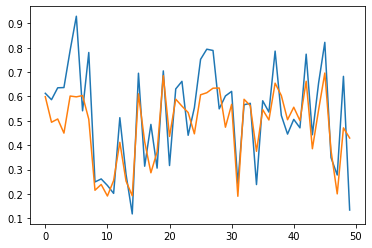

In [61]:
##Plot from best model of bayesian tuner
plt.plot(y_test[:50]) # plot first line
plt.plot(lstm_predictions[:50]) # plot second line

In [66]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 36)            7200      
                                                                 
 lstm_1 (LSTM)               (None, 36)                10512     
                                                                 
 dense (Dense)               (None, 1)                 37        
                                                                 
Total params: 17,749
Trainable params: 17,749
Non-trainable params: 0
_________________________________________________________________


#   Training new model using hyperparameters from bayesian tuner
### Using more epochs and a decayed learning rate on validation loss : for better learning out of information in dataset

In [94]:
#Creating our lstm model with hyperparameters of best optimsed model after bayesianoptimisation 
def create_model(input_shape,activation='tanh',recurrent_dropout=0.15,num_rnn_layers=2,num_units=36):
    model = Sequential()
    for layers in range(num_rnn_layers):
        if layers==0:
            model.add(LSTM(units=num_units, activation=activation, return_sequences=True,recurrent_dropout = recurrent_dropout,input_shape=input_shape))
        elif layers==(num_rnn_layers-1):
            model.add(LSTM(units=num_units, activation=activation,return_sequences=False, recurrent_dropout = recurrent_dropout,))
        else:
            model.add(LSTM(units=num_units, activation=activation,return_sequences=True, recurrent_dropout = recurrent_dropout,))
          
    model.add(Dense(1))

    model.summary()
    return model

In [95]:
input_shape = (24, 13)
model =create_model(input_shape)

LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=4, min_lr=0.000001)
callbacks_list = [LR]
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.01),metrics=[RootMeanSquaredError()])

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 24, 36)            7200      
                                                                 
 lstm_17 (LSTM)              (None, 36)                10512     
                                                                 
 dense_8 (Dense)             (None, 1)                 37        
                                                                 
Total params: 17,749
Trainable params: 17,749
Non-trainable params: 0
_________________________________________________________________


In [96]:
model_summary = model.fit(X_train, y_train, validation_split=0.20,callbacks=callbacks_list ,epochs=40)

Epoch 1/40
613/613 [==============================] - 38s 47ms/step - loss: 0.0238 - root_mean_squared_error: 0.1542 - val_loss: 0.0194 - val_root_mean_squared_error: 0.1391 - lr: 0.0100
Epoch 2/40
613/613 [==============================] - 28s 46ms/step - loss: 0.0175 - root_mean_squared_error: 0.1323 - val_loss: 0.0156 - val_root_mean_squared_error: 0.1248 - lr: 0.0100
Epoch 3/40
613/613 [==============================] - 29s 47ms/step - loss: 0.0153 - root_mean_squared_error: 0.1239 - val_loss: 0.0152 - val_root_mean_squared_error: 0.1234 - lr: 0.0100
Epoch 4/40
613/613 [==============================] - 30s 48ms/step - loss: 0.0138 - root_mean_squared_error: 0.1174 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1146 - lr: 0.0100
Epoch 5/40
613/613 [==============================] - 28s 46ms/step - loss: 0.0123 - root_mean_squared_error: 0.1110 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1058 - lr: 0.0100
Epoch 6/40
613/613 [==============================] - 27s 45ms/st

Prediction

In [97]:
#predict using bayesian best trained model
lstm_predictions = model.predict(X_test)

lstm_score = r2_score(y_test, lstm_predictions)
print("R^2 Score of LSTM model = ",lstm_score)

R^2 Score of LSTM model =  0.9068690546913851


Prediction : Visualisation

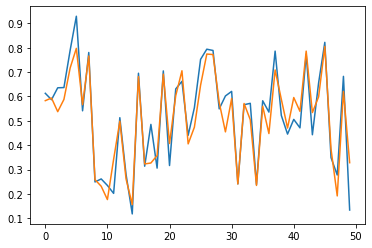

In [98]:
##Plot from best model of bayesian tuner
plt.plot(y_test[:50]) # plot first line
plt.plot(lstm_predictions[:50]) # plot second line

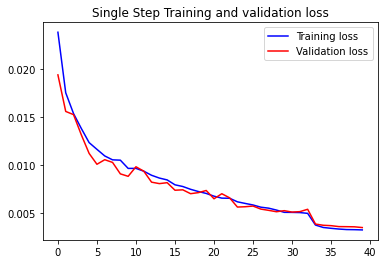

In [99]:
plot_train_history(model_summary,'Single Step Training and validation loss')